In [1]:
#import package
from package.Mat_sim import DataSim
from package.Data_sim import LinearSEMSimulator
from package.FDBNL import Fed_DBN,opt_boundary
import numpy as np
from package.Metric import mea_acc
import pickle

### Data simulation

In [2]:
n_samples = 500
d_vars = 5
p = 4  # expected degree
eta = 1.5  # Decay parameter
lag = 3  # Number of lags
K = 5 # number of agents 
n_agent = n_samples // K # number of samples per agent


# Instantiate the DataSim class
data_sim = DataSim(sample_size=n_samples, d_size=d_vars, degree=p, eta=eta, lag=lag)

# Intra-slice graph
W = data_sim.W_sim() 
# Inter-slice graph
A = data_sim.A_sim()


# Instantiate the LinearSEMSimulator class
sem_type = 'gauss'
noise_scale = 1
simulator = LinearSEMSimulator(W, noise_scale)
X = simulator.simulate(n_samples, sem_type)
X_final= simulator.add_inter_slice_effects(X, A)
X_lagged = simulator.create_lagged_version(X,lag)

# preprocess of data for Fedearated learning
X_agent = X_final.reshape(K, n_agent, d_vars)
print(X_agent.shape)

X_lagged_agent = X_lagged.reshape(K, n_agent, lag * d_vars)
print(X_lagged_agent.shape)

(5, 100, 5)
(5, 100, 15)


In [6]:
bnds = opt_boundary(X_final, X_lagged, d_vars)

X_agent = np.array(X_agent, dtype=np.float64)
Y_agent = np.array(X_lagged_agent, dtype=np.float64)

SHD = []

lambda_w = 0.35
lambda_a = 0.25
w_threshold=0.3
a_threshold=0.3
# Instantiate the DYNOTEARS solver
W_est, A_est = Fed_DBN(X_agent, Y_agent, bnds,lambda_w=lambda_w, lambda_a=lambda_a, w_threshold=w_threshold, a_threshold=a_threshold)

3


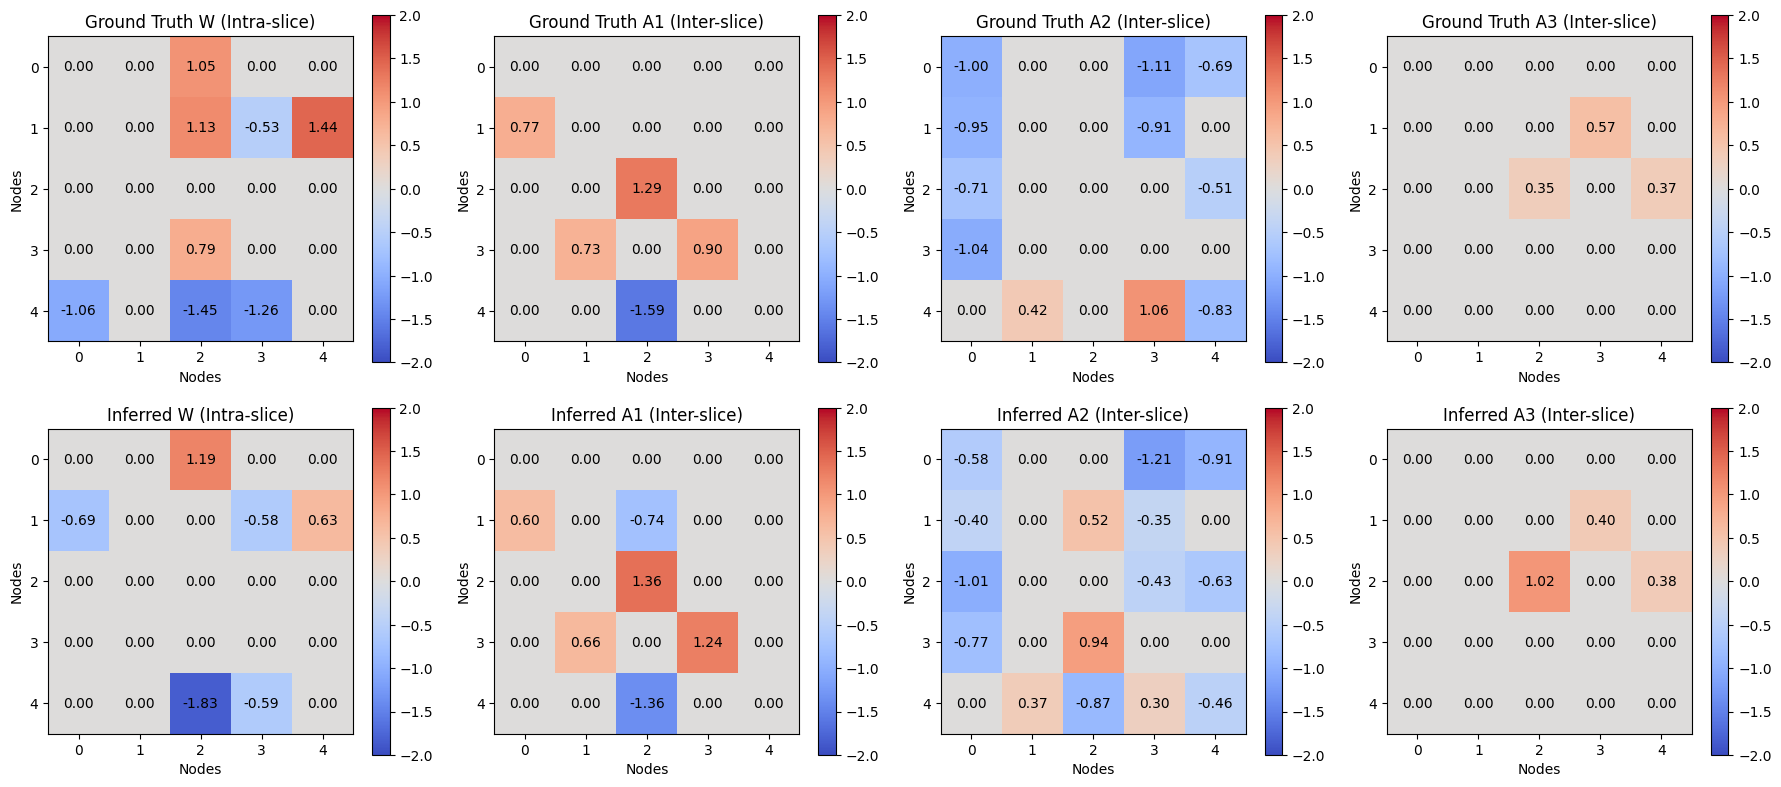

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# Ground truth matrices
W_true = W
A1_true = A[0:5,:]
A2_true = A[5:10,:]
A3_true = A[10:15,:]

# Inferred matrices
W_inferred = W_est
A1_inferred = A_est[0:5,:]
A2_inferred = A_est[5:10,:]
A3_inferred = A_est[10:15,:]

def p_vary(matrix, title, subplot_index):
    plt.subplot(2, 4, subplot_index)
    im = plt.imshow(matrix, cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    # Add text annotations inside each cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="black")

# Set up the figure
plt.figure(figsize=(18, 8))

# Plot ground truth matrices with annotations
p_vary(W_true, "Ground Truth W (Intra-slice)", 1)
p_vary(A1_true, "Ground Truth A1 (Inter-slice)", 2)
p_vary(A2_true, "Ground Truth A2 (Inter-slice)", 3)
p_vary(A3_true, "Ground Truth A3 (Inter-slice)", 4)

# Plot inferred matrices with annotations
p_vary(W_inferred, "Inferred W (Intra-slice)", 5)
p_vary(A1_inferred, "Inferred A1 (Inter-slice)", 6)
p_vary(A2_inferred, "Inferred A2 (Inter-slice)", 7)
p_vary(A3_inferred, "Inferred A3 (Inter-slice)", 8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
